# Quick Start

This guide will help you get started accessing, processing, and analyzing data from Hydrosat's pathfinder missions.

## 1. Accessing Hydrosat's STAC API

### 1.1 Import dependencies.

In [87]:
import json
import pystac
from pystac_client import Client
import base64

### 1.2 Authenticate and connect to the STAC API.

Before running this next cell, you'll need to create a `creds.json` file in the same directory as this notebook.

The format of the file should be:

```
{
"username":"your_username",
"password":"your_password"
}
```

(Leave the quotation marks as is.)

Let's read the json file.

In [88]:
with open('creds.json') as f:
    creds = json.loads(f.read())

This next cell will endecode the `username:password` combination and use it to authorize access to the STAC API given by the `cat_url` endpoint. You don't need to make any changes here.

In [89]:
userpass = f"{creds['username']}:{creds['password']}"
b64 = base64.b64encode(userpass.encode()).decode()
headers = {'Authorization':'Basic ' + b64}

cat_url = 'https://stac.hydrosat.com/'
catalog = Client.open(cat_url, headers)

Now you're ready to explore the STAC catalog! The catalog consists of a series of collections containing STAC items, each of which represents an individual scene. 

VanZyl-1 data is available in four collections:
1. ```vz-liri-l1a```: Level-1A LWIR data
2. ```vz-viri-l1a```: Level-1A VNIR data 
3. ```vz-l1b```: Level-1B data
4. ```vz-l2```: Level-2 data (surface reflectance and surface temperature)

## 2. Searching the catalog for data that meets your criteria

Let's explore how you can use the ```catalog.search()``` function to find data from a specific place and time.

### 2.1 Define search terms.

First, we'll specify a collection to search.

In [106]:
collection_id = 'vz-l2' # the L2 collection contains VZ-1 surface reflectance and surface temperature data

We'll also define a bounding box to search within. Points, polygons, and other geometries are also valid search filters.

In [91]:
# Format: [left, bottom, right, top]
bbox = [113.183, -42.905, 155.974, -11.713] # <- This bbox covers all of Australia

We can also specify a date range of interest. Note that there are a few different ways you can format this range.

In [92]:
start_date = "2025-04-15"
start_time = "T00:00:00Z"

end_date = "2025-07-15"
end_time = "T00:00:00Z"
datetime_range = [start_date+start_time, end_date+end_time]

### 2.2 Execute the search.

In [107]:
search = catalog.search(
        collections = [collection_id], # Look for scenes in this collection
        bbox = bbox, # Look for scenes that intersect the defined bbox
        datetime = datetime_range, # Look for scenes acquired within the defined datetime range (inclusive)
        max_items = 20 # Limit the total number of items returned
    )

items = list(search.items())
items.reverse() # Reorder so that the list of items goes from from oldest to newest

print(f"Found {len(items)} {collection_id} items intersecting the area of interest between {start_date} and {end_date}.\n")
print("Item IDs:")
for i, item in enumerate(items):
    print(f"{i+1}. {item.id}")

Found 20 vz-l2 items intersecting the area of interest between 2025-04-15 and 2025-07-15.

Item IDs:
1. VZ01_L2_20250426_010403
2. VZ01_L2_20250426_010413
3. VZ01_L2_20250430_010828
4. VZ01_L2_20250501_022012
5. VZ01_L2_20250501_022022
6. VZ01_L2_20250505_022441
7. VZ01_L2_20250506_002657
8. VZ01_L2_20250521_024015
9. VZ01_L2_20250521_024024
10. VZ01_L2_20250611_023306
11. VZ01_L2_20250611_023316
12. VZ01_L2_20250615_023458
13. VZ01_L2_20250623_010508
14. VZ01_L2_20250623_010518
15. VZ01_L2_20250623_010527
16. VZ01_L2_20250710_022208
17. VZ01_L2_20250710_022218
18. VZ01_L2_20250713_011229
19. VZ01_L2_20250714_022323
20. VZ01_L2_20250714_022333


## 3. What's in an item anyway?

Let's explore the concept of a STAC item. At a high level, each item represents a single VZ-1 scene as a GeoJSON feature. 

For this example, we'll focus on an item with a specific known ID. 

In [108]:
item = [item for item in items if '20250506_002657' in item.id][0] # Grab item from the list with a specific ID substring
print(f"ID: {item.id}")

ID: VZ01_L2_20250506_002657


We can extract the scene's date and time with the ```datetime``` operator.

In [95]:
print(f"Datetime: {item.datetime}")

Datetime: 2025-05-06 00:26:57.509264+00:00


The ```bbox``` field describes the scene's spatial footprint.

In [96]:
print(f"Bounding Box: {item.bbox}")

Bounding Box: [148.81743441637272, -29.173144443074726, 149.65843999982818, -28.41489050690791]


Several scene characteristics are included under ```properties```.

**⚠️ Note:** any of the item's ```properties``` can be used as a search filter. For example, to find scenes acquired with an off-nadir angle between -10 and 10 degrees, we could add ```query={"view:off_nadir": {"gte":-10, "lte":10}}``` as another argument to ```catalog.search()```.

In [97]:
print(f"Properties:")
for key, value in item.properties.items():
    print(f"  {key}: {value}")

Properties:
  start_datetime: 2025-05-06T00:26:52.533010Z
  end_datetime: 2025-05-06T00:27:02.485519Z
  created: 2025-07-23T23:03:28.735Z
  hydrosat:scene_id: VZ01_L2_20250506_002657
  datetime: 2025-05-06T00:26:57.509264Z
  processing:lineage: Hydrosat Level-2 LST and SR processing
  eo:cloud_cover: 0.0005715368783121281
  eo:snow_cover: 0
  hydrosat:capture_type: image
  hydrosat:day_night: day
  instruments: ['liri-v1-01', 'viri-v1-01']
  platform: vanzyl-01
  processing:software: {'vz-l1b': 'hydrosat.vz_l1b==0.0.0+dev-2025-07-01T19:23:25+0000', 'vz-liri-l0': 'hydrosat.vz_liri_l0==0.18.2.dev133+g9f3cc60', 'vz-liri-l0b': 'hydrosat.vz_liri_l0b==0.18.2.dev32+g1debc9d', 'vz-liri-l1a': 'hydrosat.vz_liri_l1a==0.0.0+dev-2025-07-01T19:15:39+0000', 'vz-telemetry': 'hydrosat.vz_telemetry==0.18.2.dev18+ga0564b2', 'vz-viri-l0': 'hydrosat.vz_viri_l0==0.18.2.dev47+g16aefb1', 'vz-viri-l1a': 'hydrosat.vz_viri_l1a==0.0.0+dev-2025-07-01T19:14:02+0000', 'vz-l2': 'hydrosat.vz_l2==0.0.0+dev-2025-07-01T1

Details about the data and metadata, including download links, are provided under ```assets```. We'll print the list of available assets below.

**⚠️ Note:** The data or metadata file corresponding to each asset can be accessed using the pre-signed S3 URL under the ```href``` field. These URLs are unique to each user and enable easy, one-click access to imagery. They expire after 24 hours.

In [111]:
print(f"Assets:")
for key, _ in item.assets.items():
    print(f"  {key}")

Assets:
  metadata
  BLUE_SR
  GREEN_SR
  LWIR1_BT
  LWIR2_BT
  NIR_SR
  RED_SR
  REDEDGE1_SR
  REDEDGE2_SR
  REDEDGE3_SR
  LWIR1_EMIS
  LWIR2_EMIS
  LST
  LST_UNCERTAINTY
  quality_assurance
  CLOUD_MASK
  THUMBNAIL_LST
  PREVIEW_LST
  THUMBNAIL
  PREVIEW


## 4. Visualizing item footprints on a map

Now that we have a better understanding of what's contained in a STAC item, let's map the item geometries. You can inspect any item to see more information about it.

**⚠️ Note:** Certain IDEs will render this map differently.
- If you're using VSCode, you'll see an interactive map in this Jupyter notebook.
- If you're using Spyder, you'll need to open ```map.html``` in a browser window.

In [99]:
import geopandas as gpd

gdf = gpd.GeoDataFrame.from_features(items, crs="epsg:4326")[["geometry"]]
gdf['ID'] = [item.id for item in items]
gdf['Date'] = [item.datetime.date().strftime('%Y-%m-%d') for item in items]
gdf['Time (UTC)'] = [item.datetime.time().strftime('%H:%M:%S') for item in items]

m = gdf.explore(color='magenta', style_kwds={"fillOpacity": 0.7, "weight": 1})
m.save("map.html")
m

## 5. Visualizing LST

Land surface temperature data is provided as a Level-2 asset. Here, we'll walk through the process of accessing, scaling, and plotting LST. 

First, we'll access the LST asset and open the cloud-optimized geotiff file using ```rioxarray```.

In [100]:
import rioxarray as rxr
from matplotlib import pyplot as plt
import numpy as np

lst_href = item.assets['LST'].href
lst = rxr.open_rasterio(lst_href).squeeze()

We'll handle pixels with no data by converting them to NaN.

In [101]:
lst = lst.where(lst > 0, np.nan)

We'll need to apply a scaling factor from the metadata to ensure LST is displayed in units Kelvin.

In [102]:
lst_scaling_factor = item.assets['LST'].extra_fields.get('raster:bands')[0]['scale'] # Grab the scaling factor from the STAC metadata
lst *= lst_scaling_factor

Now, let's plot the image.

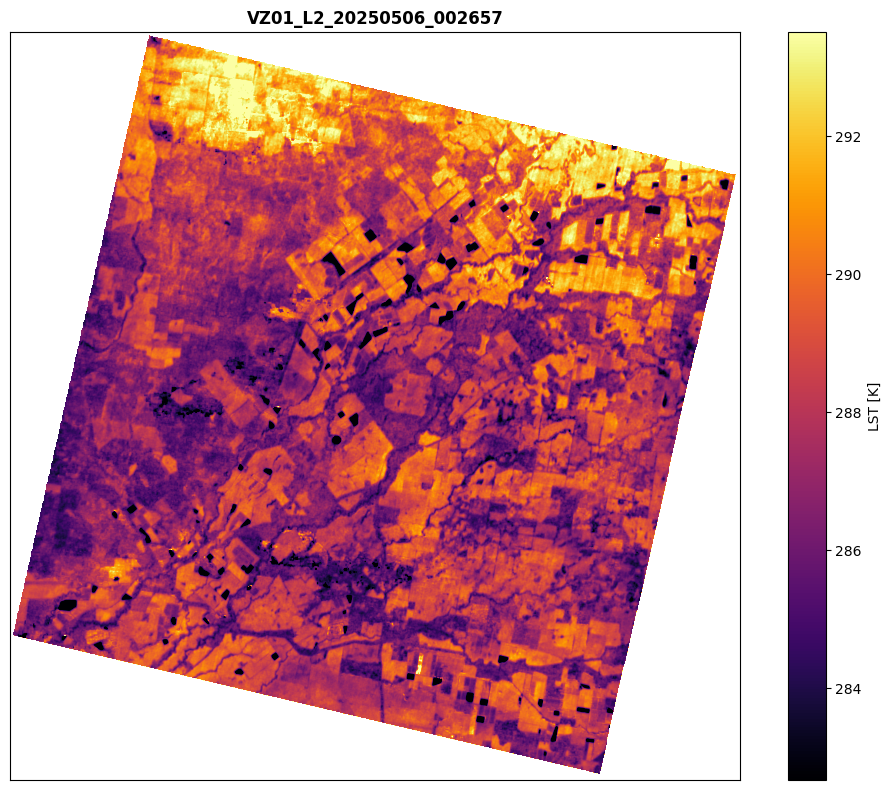

In [112]:
# Plot LST image
plt.figure(figsize=(10,8))
vmin, vmax = np.nanpercentile(lst, 1), np.nanpercentile(lst, 99)
plot = plt.imshow(lst, cmap=plt.cm.inferno, vmin=vmin, vmax=vmax)
plt.colorbar(plot, label='LST [K]')
plt.xticks([])
plt.yticks([])
plt.title(item.id, weight='bold')
plt.tight_layout()
plt.show()

Finally, we'll plot a distribution of LST values across the entire scene.

Mean LST = 288.16
Median LST = 287.86


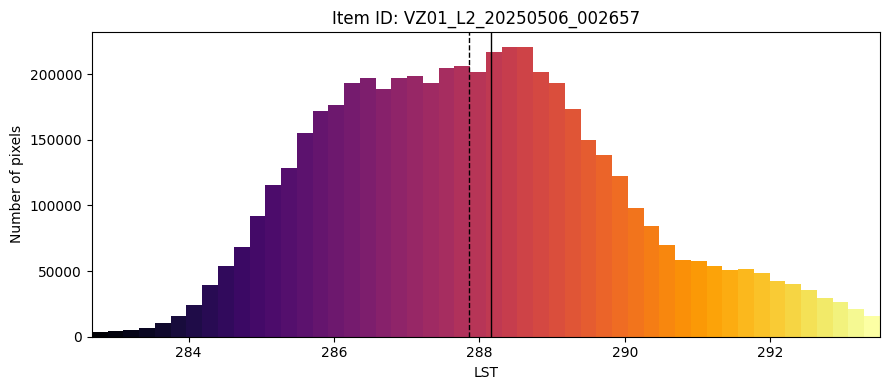

In [104]:
# Calculate mean and median LST
mean = lst.mean().values
median = lst.median().values

print(f'Mean LST = {mean:.2f}')
print(f'Median LST = {median:.2f}')

# Plot LST value distribution
plt.figure(figsize=(9, 4))
n, bins, patches = plt.hist(lst.values.flatten(), bins=50, range=(vmin,vmax))
# Apply colors to bars based on bin edges
for c, patch in zip(np.linspace(0, 1, len(patches)), patches):
    patch.set_facecolor(plt.cm.inferno(c))
[plt.axvline(val, color='k', linewidth=1, linestyle=ls) for val, ls in zip([mean, median], ['-', '--'])] # Plot mean and median as vertical lines
plt.xlim([vmin, vmax])
plt.title(f'Item ID: {item.id}')
plt.xlabel("LST")
plt.ylabel("Number of pixels")
plt.tight_layout()
plt.show()

That's it! You've done your first end-to-end analysis with Hydrosat data.